In [4]:
!pip install tfrecord_lite
!pip install jiwer

In [5]:
%matplotlib inline

from torch import nn
import torch.optim
import matplotlib.pyplot as plt

import math
import time

import sys
# sys.path.append('/content/drive/MyDrive/Colab Notebooks/Transformer2')

from transformer import Encoder, Decoder, Transformer
from validate import Validate
from data_formatting import Data_Formatting
from train import Train
from variables import INPUT_DIM, OUTPUT_DIM, D_MODEL, N, H, D_FF, DROPOUT, \
LEARNING_RATE, N_EPOCHS, CLIP, device, SRC_PAD_IDX, TRG_PAD_IDX, N_VAL

In [6]:
def make_model():
    enc = Encoder(INPUT_DIM, 
                D_MODEL, 
                N, 
                H, 
                D_FF, 
                DROPOUT,
                d.max_ecog_sz
                )
    dec = Decoder(OUTPUT_DIM, 
                D_MODEL, 
                N, 
                H, 
                D_FF, 
                DROPOUT
                )
    return Transformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, D_MODEL).to(device)

In [7]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [8]:
d = Data_Formatting('400');

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
76
76
76


In [9]:
model = make_model()
model.apply(initialize_weights);
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [10]:
t_val = Validate(d.train_data.dataset, d.vocab)
v_val = Validate(d.val_data.dataset, d.vocab)
test_val = Validate(d.test_data.dataset, d.vocab)
t = Train(d.train_data.dataset)
wer_val_data = list()
wer_train_data = list()

In [11]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    train_loss, optimizer, criterion = t.train(model, optimizer, criterion, CLIP)
    
    if epoch % 5 == 0:
        wer_train_data.append(t_val.validate(model))
        wer_val_data.append(v_val.validate(model))
        if v_val.min_WER == v_val.WER:
            torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/models/EFC401/model.pt')
    end_time = time.time()
    epoch_mins, epoch_secs = t.epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\tWER Training Data: {wer_train_data[-1]} | WER Validation Data: {wer_val_data[-1]}')
    print()

Epoch: 01 | Time: 1m 15s
	Train Loss: 8.129 | Train PPL: 3391.627
	WER Training Data: 0.9666746031746031 | WER Validation Data: 0.9663968253968253

Epoch: 02 | Time: 0m 17s
	Train Loss: 6.177 | Train PPL: 481.305
	WER Training Data: 0.9666746031746031 | WER Validation Data: 0.9663968253968253

Epoch: 03 | Time: 0m 17s
	Train Loss: 5.503 | Train PPL: 245.403
	WER Training Data: 0.9666746031746031 | WER Validation Data: 0.9663968253968253

Epoch: 04 | Time: 0m 17s
	Train Loss: 4.562 | Train PPL:  95.742
	WER Training Data: 0.9666746031746031 | WER Validation Data: 0.9663968253968253

Epoch: 05 | Time: 0m 17s
	Train Loss: 3.522 | Train PPL:  33.836
	WER Training Data: 0.9666746031746031 | WER Validation Data: 0.9663968253968253

Epoch: 06 | Time: 1m 13s
	Train Loss: 2.603 | Train PPL:  13.505
	WER Training Data: 0.5802341269841269 | WER Validation Data: 0.8529444444444444

Epoch: 07 | Time: 0m 17s
	Train Loss: 1.846 | Train PPL:   6.335
	WER Training Data: 0.5802341269841269 | WER Validat

KeyboardInterrupt: ignored

In [17]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/models/EFC401/model.pt'))
test_val.validate(model)

0.518888888888889

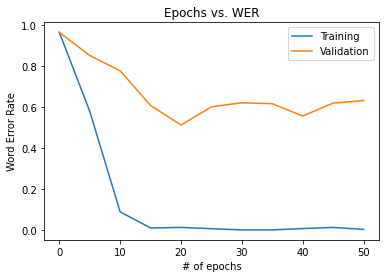

In [12]:
x_epoch = list()

for i in range(len(wer_train_data) - 1):
    x_epoch.append(i * N_VAL)

plt.plot(x_epoch, wer_train_data[:-1], label='training data wer')
plt.plot(x_epoch, wer_val_data[:-1], label='testing data wer')
plt.legend(["Training", "Validation"])
plt.xlabel("# of epochs")
plt.ylabel("Word Error Rate")
plt.title("Epochs vs. WER")
plt.savefig('/content/drive/MyDrive/Colab Notebooks/models/EFC401/EFC401_train_v_val.png');

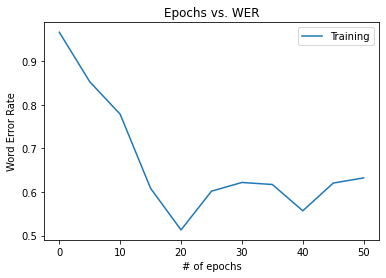

In [13]:
plt.plot(x_epoch, wer_val_data[:-1], label='testing data wer')
plt.legend(["Training", "Validation"])
plt.xlabel("# of epochs")
plt.ylabel("Word Error Rate")
plt.title("Epochs vs. WER");
plt.savefig('/content/drive/MyDrive/Colab Notebooks/models/EFC401/EFC401_val.png');

In [14]:
print(t_val.min_WER, t_val.WER)
t_val.min_df.head()

0.0 0.0


,Actual,Predicted
0,young people participate in athletic activities,young people participate in athletic activities
1,did dad do academic bidding,did dad do academic bidding
2,tina turner is a pop singer,tina turner is a pop singer
3,why yell or worry over silly items,why yell or worry over silly items
4,get a calico cat to keep the rodents away,get a calico cat to keep the rodents away


In [15]:
print(v_val.min_WER, v_val.WER)
v_val.min_df.head(25)

0.5130555555555556 0.579031746031746


,Actual,Predicted
0,aluminium cutlery can often be flimsy,why yell or worry over silly
1,she is thinner than i am,this was easy for us us
2,young people participate in athletic activities,a good attitude is unbeatable the
3,dad did dad do academic bidding,did dad do academic bidding bidding
4,when all else fails use force,when all else fails use force
5,jane may earn more money by working hard,jane may earn more money by working hard
6,a roll of wire lay near the wall,where were you while we were away away
7,although always alone we survive,although always alone we survive
8,those musicians harmonize marvellously,those musicians harmonize marvellously
9,swing your arm as high as you can,he will allow a rare lie lie lie


In [18]:
print('WER:', test_val.min_WER)
test_val.df.head()

WER: 0.518888888888889


,Actual,Predicted
0,aluminium cutlery can often be flimsy,although always alone we survive survive
1,she is thinner than i am,this was easy for us us
2,young people participate in athletic activities,a good attitude is unbeatable the
3,dad did dad do academic bidding,did dad do academic bidding bidding
4,when all else fails use force,when all else fails use force
